# Project 2: Predicting Housing Prices with Linear Regression

## Introduction & Problem Statement

Determing the sale price of a house is often complicated due to the sheer number of variables that influence pricing decisions. However, with enough data, we can create a linear regression model that can help in determining the most important features of a home and accurately predict housing prices.

With this in mind, the particular problem I'm tackling is: <b>how can we use a linear regression model to best predict house sale prices?</b>

This information can then be used to help property owners maximize the value of their home and increase the sale price of their property on the market.

Using a housing dataset from Ames, Iowa, I've attempted to create a linear regression model that predicts housing sale prices, based on over 2000 housing observations and more than 80 features e.g. square footage and kitchen quality using various feature engineering, selection and regularization techniques.

In this project, I had two goals -- to create both a high performing and extremely generalizable model. This means the model should be react to unseen sets of data without large variations in accuracy. Ultimately, I'll be looking to evaluate the performance of this model using root mean squared error (RMSE) or the measure of the differences between values predicted by the model and the values observed.

## Executive Summary

To get a good grasp of the relationships between our features, I started off with a series of exploratory visualizations analyzing our target `SalePrice` and our predictors. This was followed by data cleaning, where I dealt with null and missing values. In general, I used <b>label encoding</b> to deal with categorical variables and <b>one-hot encoding</b> to deal with  nominal variables. To reduce the total number of features, I used two dimensionality reduction techniques - elimination of features according to variance, and elimination of feaetures according to pairwise correlation and correlation with target. <b>Recursive Feature Elimination</b> was also used to help weed out redudant variables.

After testing out various types of <b>regularization</b> such as Ridge, Lasso and ElasticNet regression, I settled on a Lasso regression model as it returned the best results from Kaggle. The most important predictors within this model were square footage living area, the quality of the exterior facade, basement square footage, basement quality and kitchen quality. Neighborhoods like Stone Brook and Northridge Heights also had a strong positive impact on sale price. Conversely, neighborhoods like Old Town and North Ames had a negative impact on sale price. In terms of features, homes with a second story or a second kitchen tended to have lower house prices.

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Load dataset
housing = pd.read_csv('./datasets/train.csv')

# Exploratory Visualizations

In [3]:
# Check dtypes
housing.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [4]:
# Create mask for numeric and categorical features
num_features = [col for col in housing._get_numeric_data().columns]
cat_features = [col for col in housing.select_dtypes(include=['object']).columns]

## Scatter Plots of Numeric Features

In [5]:
# Custom function for plotting of numeric features
def eda_scatterplot(dataframe, list_of_columns, target):    
    nrows = int(np.ceil(len(list_of_columns)/4))
    ncols = 4
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, nrows*2.5))
    ax = ax.ravel()
    
    for i, column in enumerate(list_of_columns):
        g = sns.regplot(data=dataframe, x=column, y=target, ax=ax[i], ci=None, color='skyblue', line_kws={'color': 'blue'})
        ax[i].set_title(column, fontsize=14)
        ax[i].set_xlabel('')
        plt.tight_layout()
    
    # Hide unused plots
    for i in range(nrows * ncols - len(list_of_columns)):
        ax[-i-1].set_visible(False) # Start from -1
    
    plt.suptitle('Scatterplot of Numeric Features vs Sale Price', fontsize=20, y=1.015)

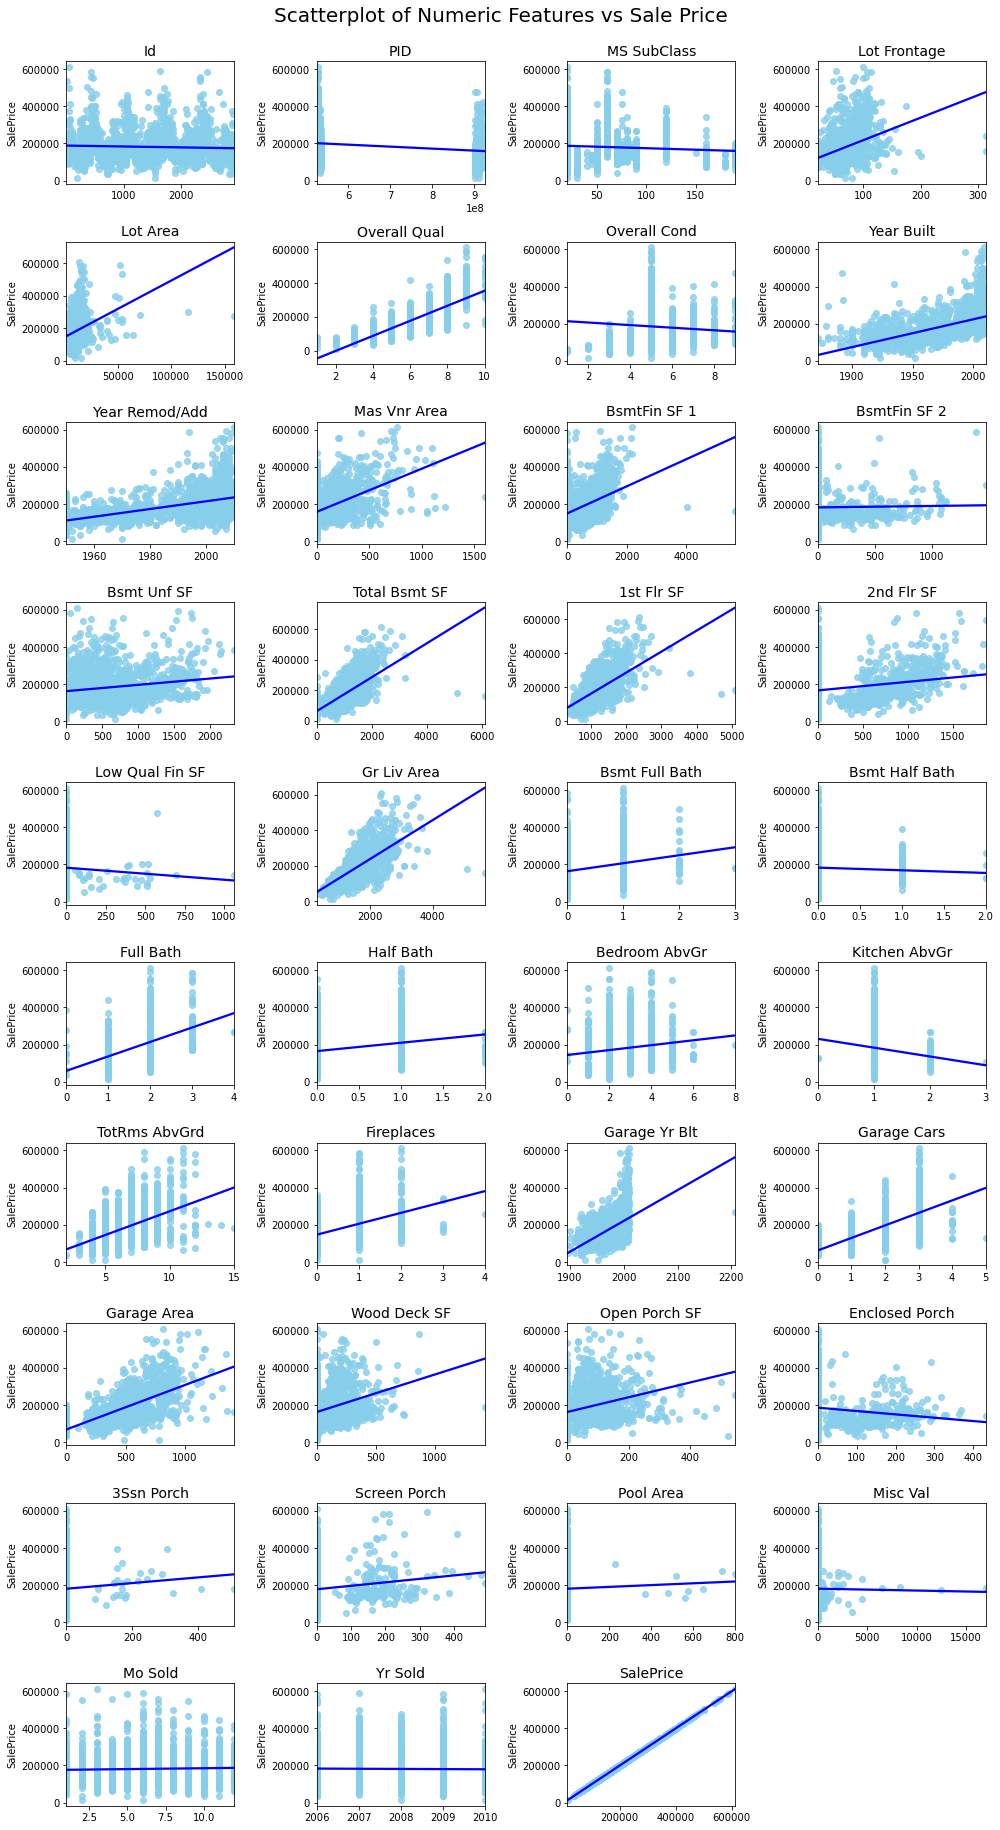

In [38]:
eda_scatterplot(housing, num_features, 'SalePrice')

Some of our features seems to have a strong positive relationship with sale price, such as `Garage Area` and `Gr Liv Area`. We can see that in general, features involving square footage have a strong correlation with sales price. This makes sense given that the size of a house is probably a key consideration for any prospective buyer. The newness or relative age of the property also has a strong correlatoin with sale price, where newer houses tend to have higher prices.

Interesting, `Overall Cond` has a negative correlation with sale price, where houses with a better conditon rating tend to have lower prices. We can also see that generally the higher the number of a specific property feature (e.g. `Fireplaces` and `Full Bath`), the higher the sale price. Some features have obvious outliers within `Gr Liv Area` and `Lot Frontage` - these seem to represent abnormally large houses within Ames.

Time-based features such as `Mo Sold` and `Yr Sold` seem to have no relationship with sale price. This is slightly odd given the financial crisis that occured in 2008. Housing prices seem to fall in a narrower range in 2008, but the average mean and median is still similar to the preceeding and following years. We can also see that there was somewhat of a housing boom in the late 90s/early 2000s where many houses were built or remodelled.

## Histograms of Numeric Features

In [7]:
# Custom function for plotting of numeric features
def eda_histograms(dataframe, list_of_columns):
    nrows = int(np.ceil(len(list_of_columns)/5)) 
    ncols = 5
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols,figsize=(14, nrows*2.5)) 
    ax = ax.ravel() 
    for i, column in enumerate(list_of_columns): 
        sns.histplot(data=housing, x=dataframe[column], kde=False, ax=ax[i], fill=False)
        ax[i].set_title(column,fontsize=14)
        ax[i].set_xlabel('')
        ax[i].tick_params(labelsize=10)
    plt.tight_layout(h_pad=-0.4, w_pad=-0.4)
    
    for i in range(nrows * ncols - len(list_of_columns)):
        ax[-i-1].set_visible(False) # Start from -1
        
    plt.suptitle('Histograms of Numeric Features', fontsize=20, y=1.015)

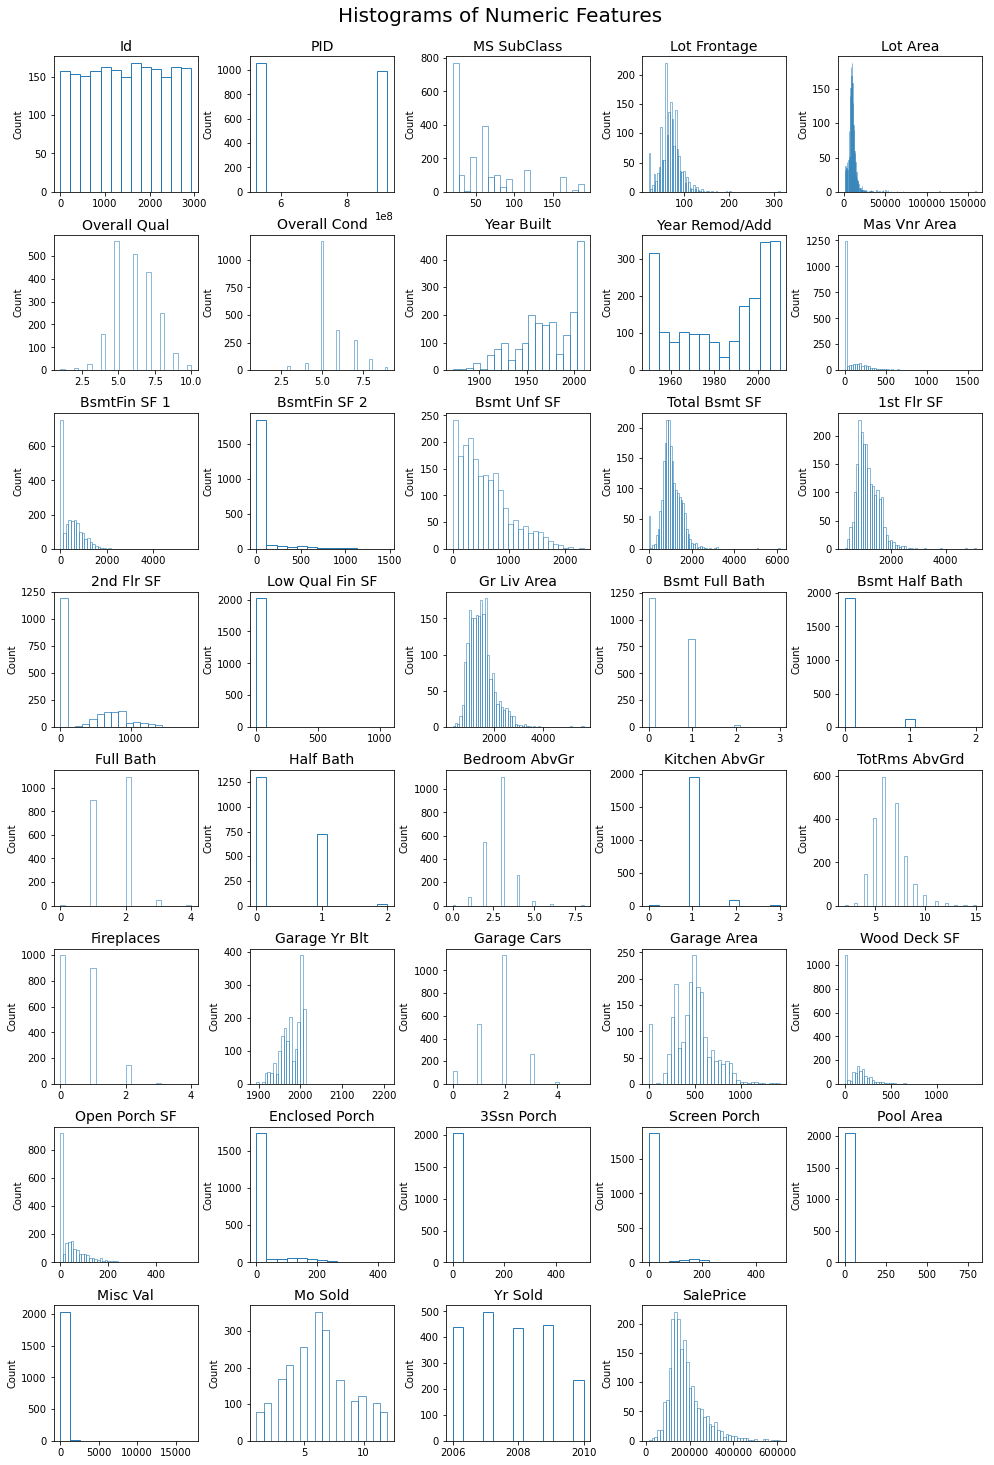

In [8]:
# Histograms of numeric data
eda_histograms(housing, num_features)

When looking at the distributions of our features, it's clear that a large number of features such as `Year Built` and even our target `SalePrice` are significantly right-skewed. These features also tend to have some degree of kurtosis, where a large number of extreme values exist. This is particularly observable in `SalePrice` and `GrLivArea`. In short, there are outliers that we'll need to deal with later on. We can also see that some features have very little variance, such as `Pool Area` -- this means that they'll be somewhat ineffective in predicting sale price.

## Boxplots of Categorical Features

In [7]:
# Custom function for plotting of categorical features
def eda_boxplotter(dataframe, list_of_columns, target):    
    nrows = int(np.ceil(len(list_of_columns)/5))
    ncols = 5
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 40))
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    
    for i, column in enumerate(list_of_columns):
        g = sns.boxplot(data=dataframe, y=column, x=target, ax=ax[i], orient='h')
        ax[i].set_title(column, fontsize=16)
        g.set(xlabel=None)
        g.set(ylabel=None)
        g.set(xticks=[0, 100000, 200000, 300000, 400000, 500000, 600000])
        g.set(xticklabels=['0k','100k','200k','300k','400k','500k','600k'])
        plt.tight_layout()
    
    # Hide unused plots
    for i in range(nrows * ncols - len(list_of_columns)):
        ax[-i-1].set_visible(False) # Start from -1
    
    plt.suptitle('Categoric Features vs Sale Price', fontsize=30, y=1.015)

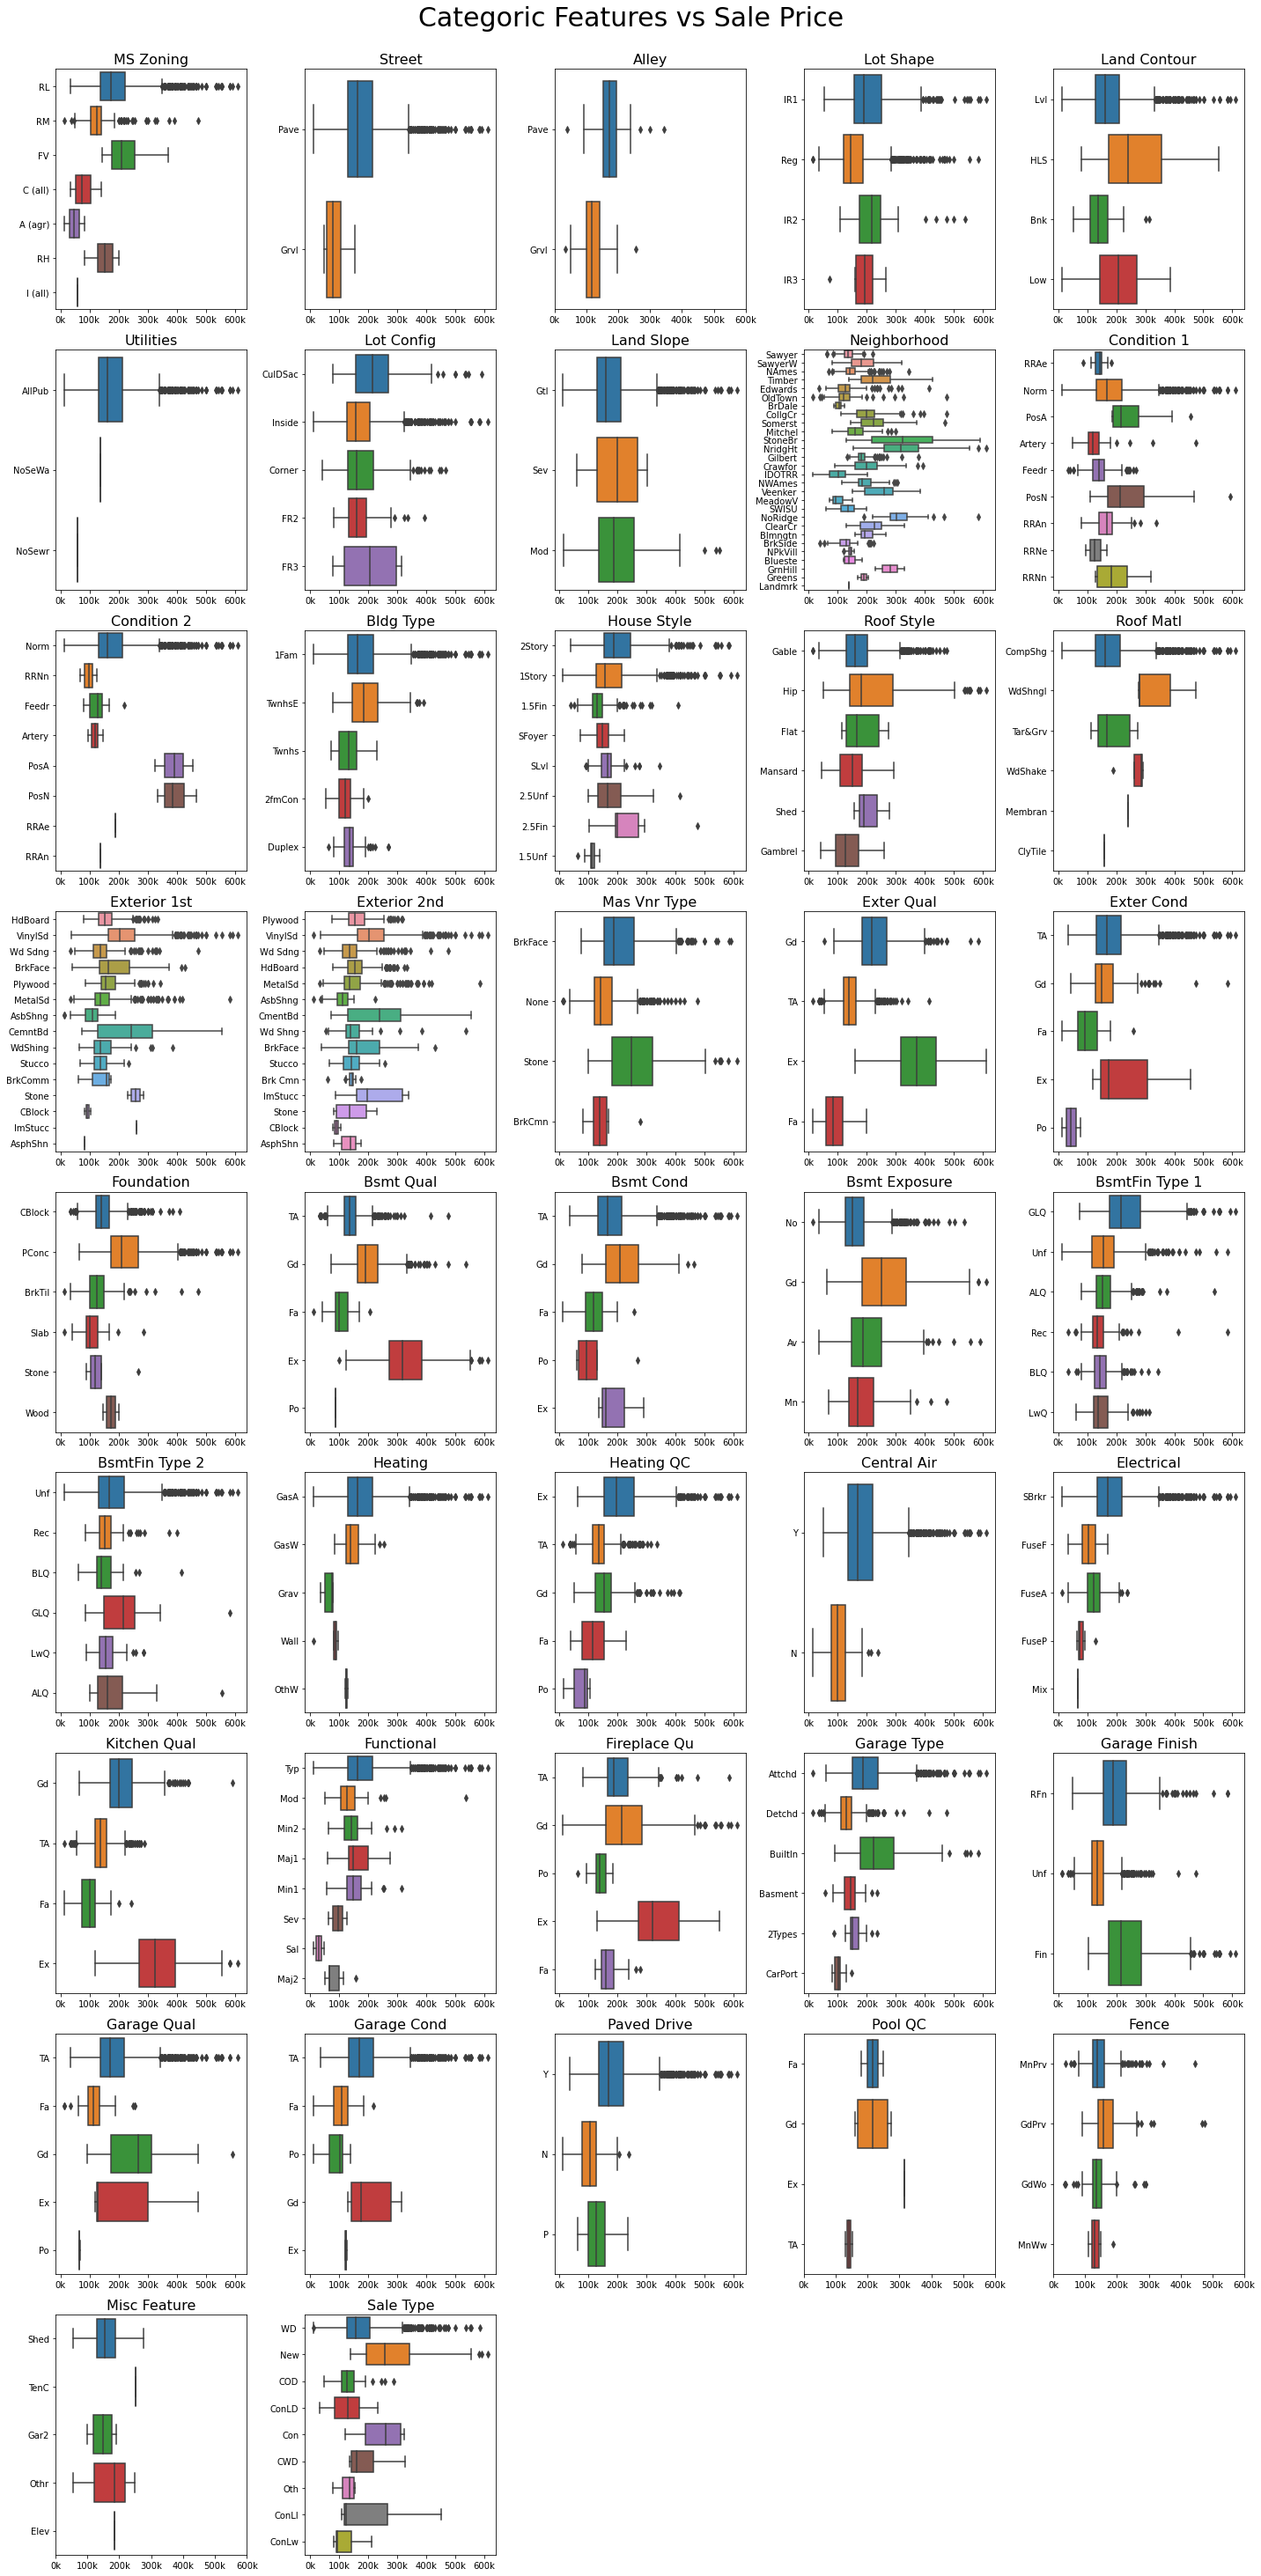

In [13]:
eda_boxplotter(housing, cat_features, 'SalePrice')

We can see that several categorical features seem to have a clear relationship with sale prices. For example, properties that have a `Paved Drive` (Yes/Partial) have a higher median sale price. Housing with high `Heating QC` also tend to have higher sale prices. This goes without saying for home functionality as well -- the more functional the home, the higher the sale price.

Paved streets and paved alleyways also have a noticeably higher median than properties with no street/alleyway access. House style also clearly affects sale price, with multi-story houses having a higher median sale price than single-story houses.

Text(0.5, 0, 'Neighborhood')

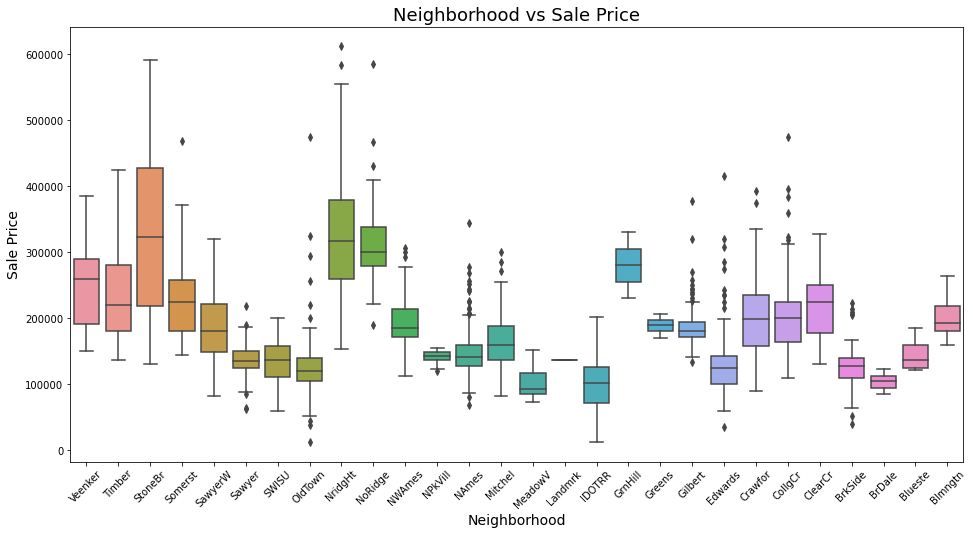

In [8]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=housing, x=housing['Neighborhood'].sort_values(ascending=False), y='SalePrice')
plt.xticks(rotation=45);
plt.title('Neighborhood vs Sale Price', fontsize=18)
plt.ylabel('Sale Price', fontsize=14)
plt.xlabel('Neighborhood', fontsize=14)

The neighborhood boxplot is of particular interest. Here, we can see that certain neighborhoods like `NridgeHt` and `NoRidge` have much higher median sale prices than other neighboods like `OldTown` and `Sawyer`.

## Strip Plots of Categorical Features

In [9]:
# Custom function for plotting of categorical features
def eda_stripplot(dataframe, list_of_columns, target):    
    nrows = int(np.ceil(len(list_of_columns)/4))
    ncols = 4
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 40))
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    
    for i, column in enumerate(list_of_columns):
        g = sns.stripplot(data=dataframe, y=column, x=target, ax=ax[i], orient='h')
        ax[i].set_title(column, fontsize=16)
        g.set(xlabel=None)
        g.set(ylabel=None)
        g.set(xticks=[0, 100000, 200000, 300000, 400000, 500000, 600000])
        g.set(xticklabels=['0k','100k','200k','300k','400k','500k','600k'])
        plt.tight_layout()
    
    # Hide unused plots
    for i in range(nrows * ncols - len(list_of_columns)):
        ax[-i-1].set_visible(False) # Start from -1
    
    plt.suptitle('Categoric Features vs Sale Price', fontsize=30, y=1.015)

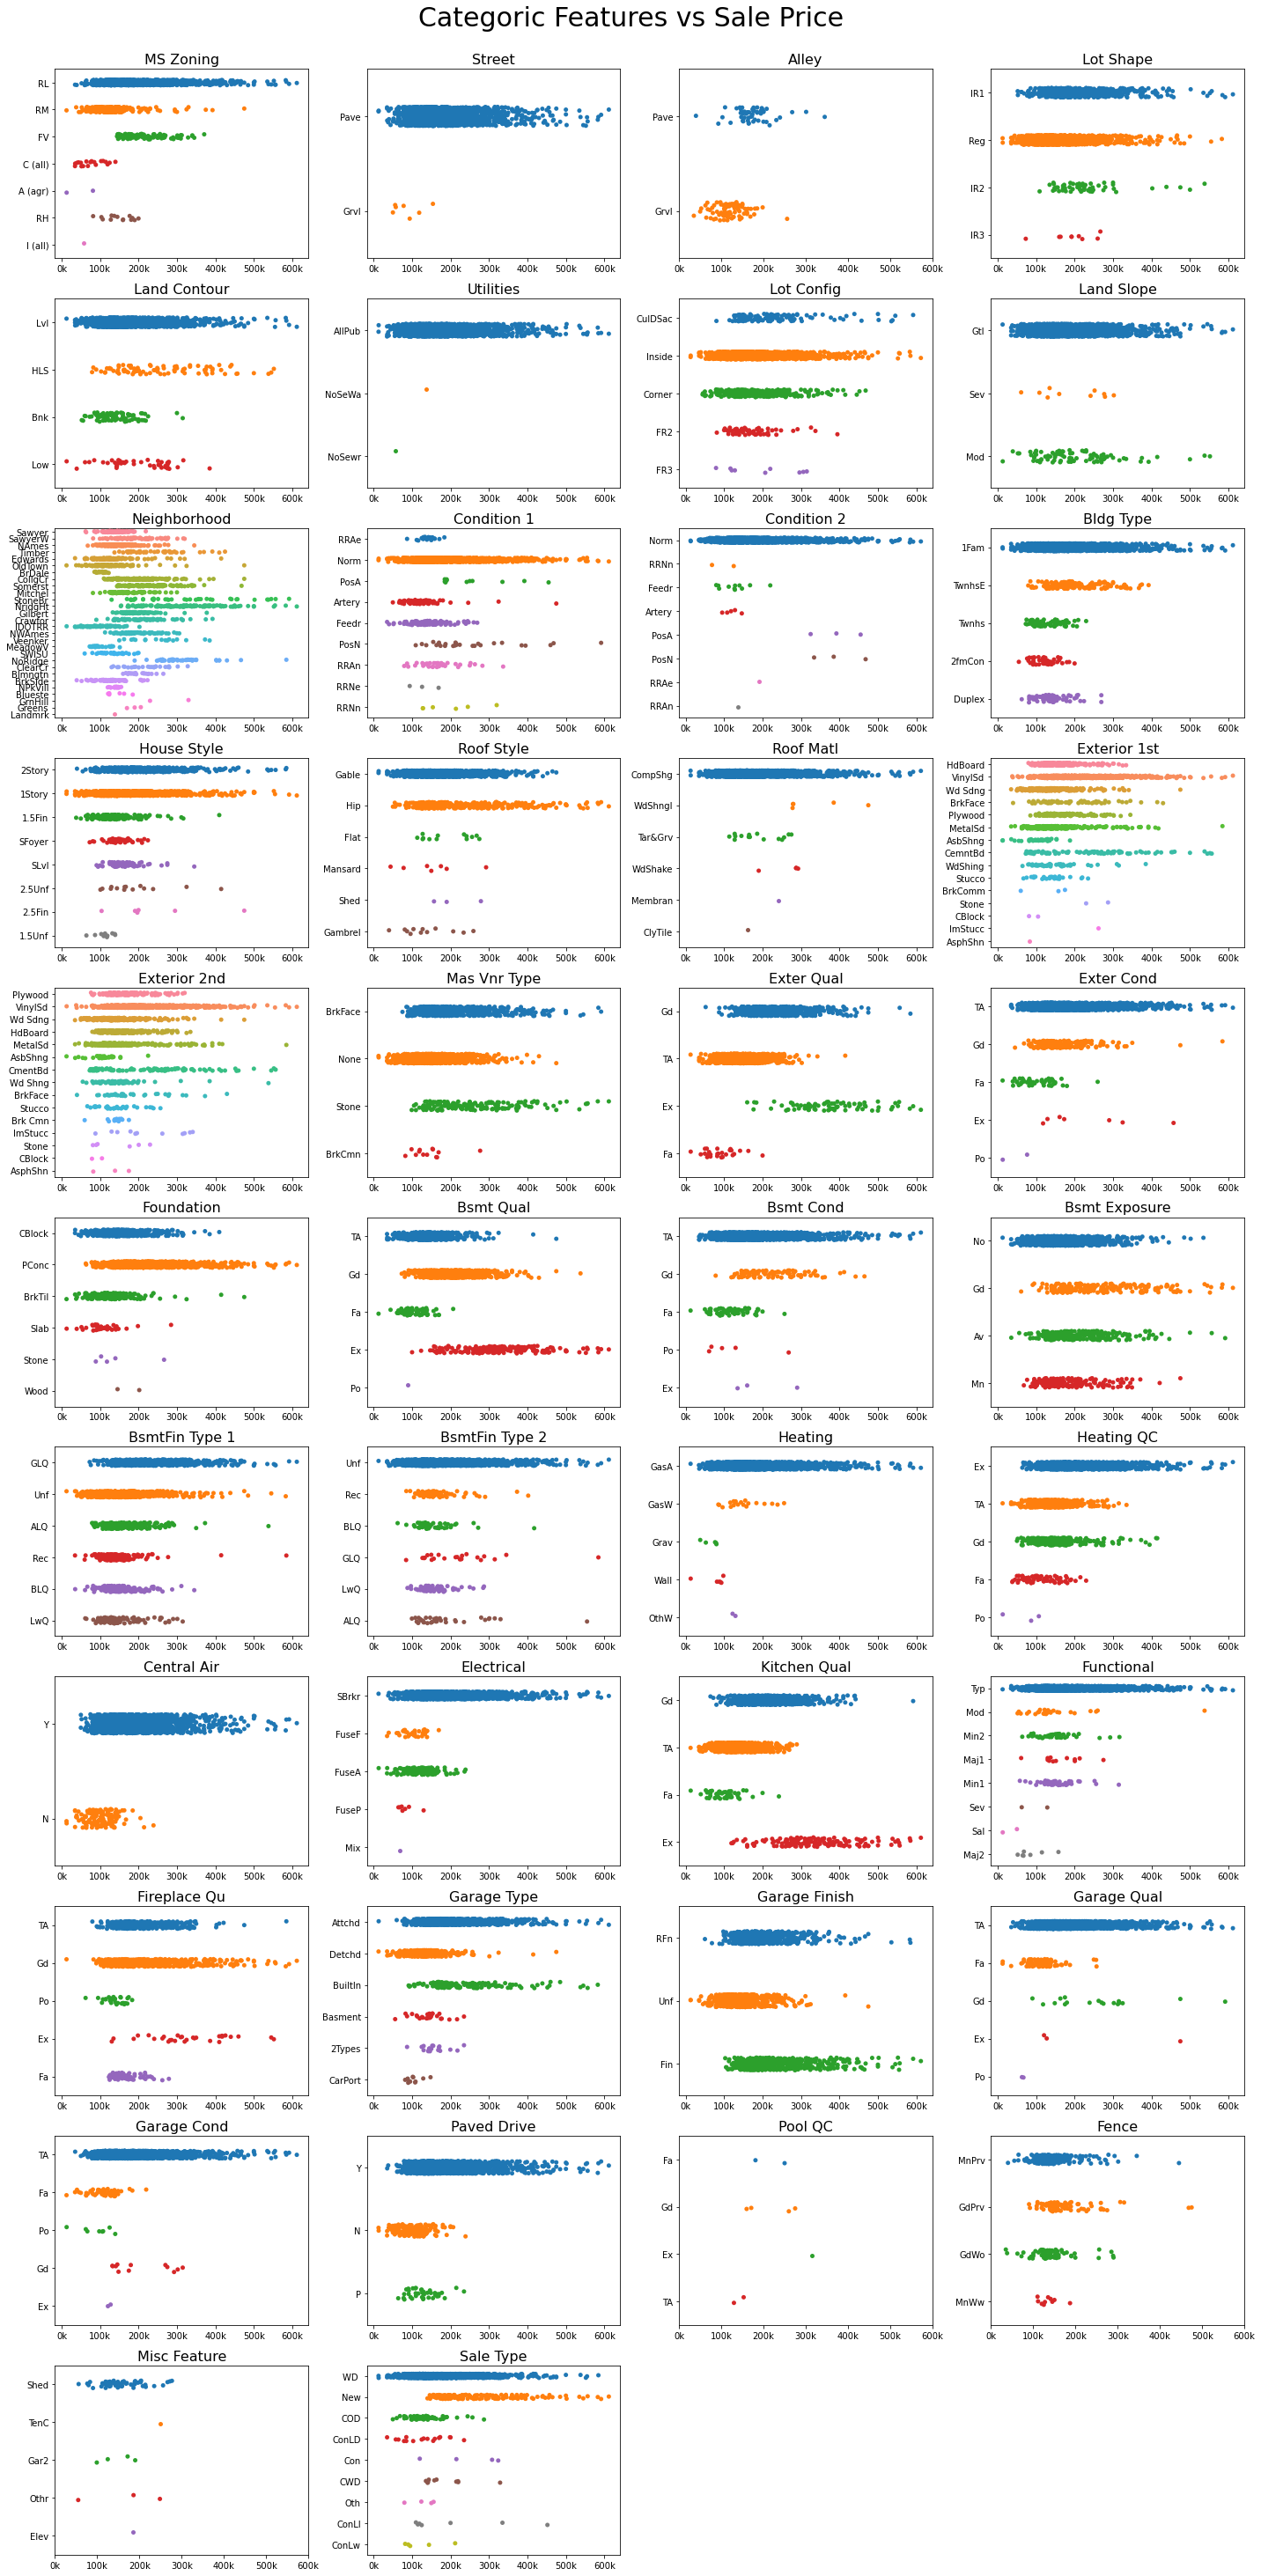

In [16]:
eda_stripplot(housing, cat_features, 'SalePrice')

When it comes to the distribution of categorical features, we can see that some features such as `Pool QC` are almost empty. In other cases, other features like `Street` and `Utilities` have almost no variance, with almost all houses landing in a single category.

Text(0.5, 0, 'Neighborhood')

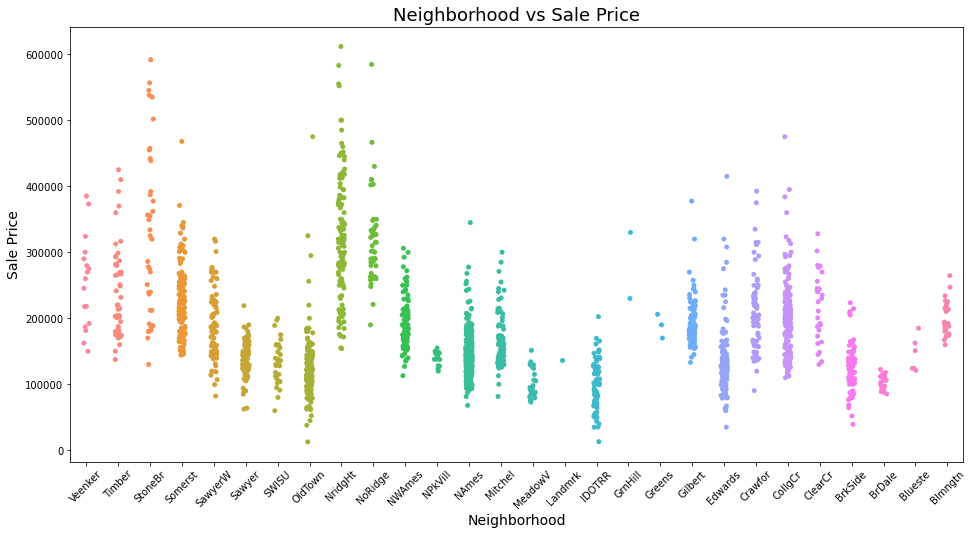

In [10]:
plt.figure(figsize=(16, 8))
sns.stripplot(data=housing, x=housing['Neighborhood'].sort_values(ascending=False), y='SalePrice')
plt.xticks(rotation=45);
plt.title('Neighborhood vs Sale Price', fontsize=18)
plt.ylabel('Sale Price', fontsize=14)
plt.xlabel('Neighborhood', fontsize=14)

Some neighboorhoods have an extremely small sample size -- this includes `Landmrk`, `GrnHill` and `Green`. These variables will probably be statistically insigificant in helping us predict housing prices.

# Model Feasibility

Multiple linear regression analysis makes several key assumptions:

- Firstly, <b>there needs to be a linear relationship between the outcome variable and the independent variables</b>. We've seen that this is largely true, with most variables having either a negative or positive linear relationship with `SalePrice`.


- Secondly, <b>there must be multivariate normality</b>, as multiple regression assumes that the residuals are normally distributed. Above, we can see that most of our variables are normally distributed. However, there are a number of variables that are highly skewed and have multimodal distributions. We can move forward on the assumption that we'll avoid using these variables for our model as far as possible.

## Checking for Multicollinearity 

- Thirdly, <b>there must not be multicollinearity</b>. Multiple regression assumes that the independent variables are not highly correlated with each other. Let's do a quick check of this now. Unfortunately, according to the heatmap below, it seems that a number of features are multicollinear, with a high coefficient magnitiude of >0.8. This isn't ideal, as multicollinearity will lower the precision of our estimate coefficients.

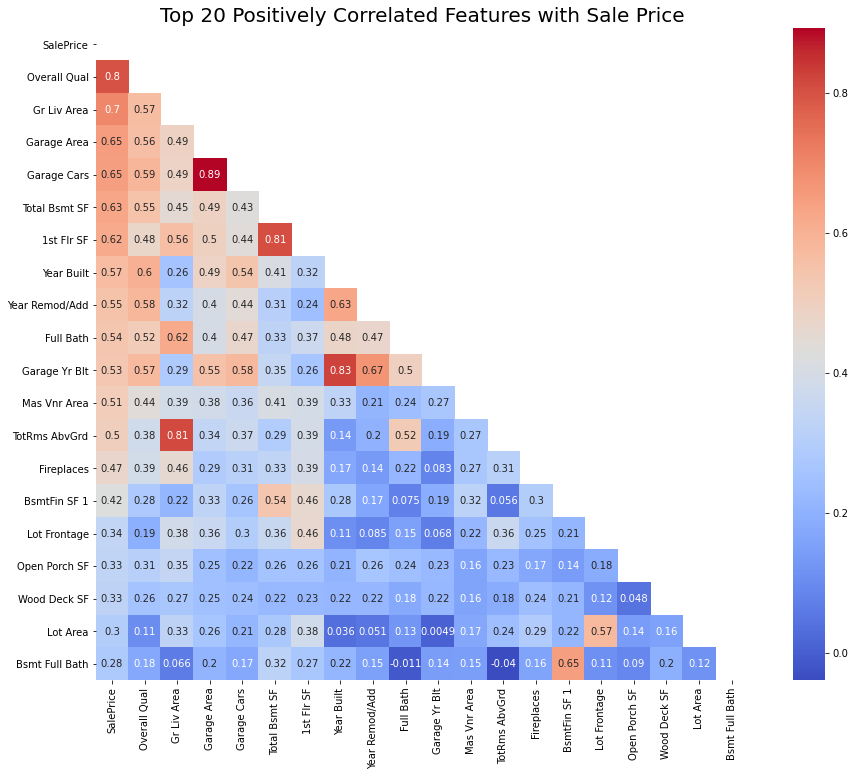

In [11]:
# Create mask for our top twenty positively correlated features
top_corr = housing.corr()['SalePrice'].sort_values(ascending=False).head(20).index

#Plot heatmap of top twenty positively correlated features.
plt.figure(figsize=(16,12))
mask = np.triu(np.ones_like(housing[top_corr].corr(), dtype=bool))
ax = sns.heatmap(housing[top_corr].corr(), cmap='coolwarm', mask=mask, square=True, annot=True)
plt.title('Top 20 Positively Correlated Features with Sale Price', fontsize=20);

## Checking for Homoscedascity

- Lastly, <b>our independent variables must be homoscedastic</b>. This means that the variance of error terms must be similar across the values of the independent variables. According to our scatterplot below, points are mostly equally distributed across all values of the independent variables. There also doesn't seem to be a clear pattern in the distribution. We can therefore conclude that the Ames housing data is homoscedastic.

In [12]:
# Temporarily fill in null values to allow for plotting of residuals
housing = housing.fillna(0)

In [13]:
# Creation of baseline linear model
features = [col for col in housing._get_numeric_data().columns if col !='SalePrice']
features
X = housing[features]
y = housing['SalePrice']

lr = LinearRegression()
lr.fit(X, y)
y_pred = lr.predict(X)

In [14]:
# Our baseline model can explain 84% of the variance in sale price. Our baseline model also has an RSME of over 30,000.
# Using this as our Kaggle model returns an RSME of over 45,000.
print('R2:', lr.score(X, y))
print('RMSE:', np.sqrt(mean_squared_error(y, y_pred)))

R2: 0.8410808671827921
RMSE: 31588.493600183694


Text(0.5, 0, 'Predicted Values')

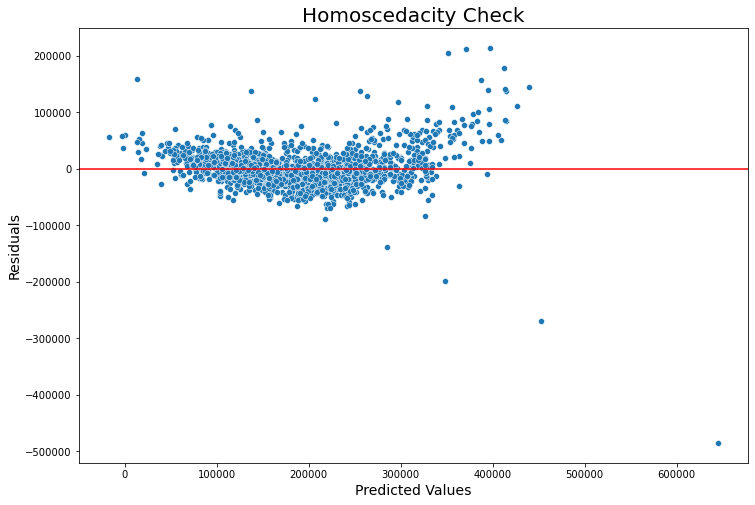

In [15]:
# Plotting residuals -- they seem to be evenly distributed with no discernable pattern
plt.figure(figsize=(12,8))
ax = sns.scatterplot(data=X, x=y_pred, y=y-y_pred)
ax.axhline(y=0, c='red')
plt.title('Homoscedacity Check', fontsize=20)
plt.ylabel('Residuals', fontsize=14)
plt.xlabel('Predicted Values', fontsize=14)

In conclusion, though using linear regression is feasible here, we'll need to work to reduce multicollinearity and deal with highly skewed features further on. By performing data cleaning, feature engineering/selection and regularization, we should be able to create a linear model that can accurately predict the sale price of houses in Ames.